In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error
from qiskit.providers.fake_provider import FakeWashingtonV2
import random

In [2]:
# fake ibm provider 
# other fake providers: https://qiskit.org/documentation/apidoc/providers_fake_provider.html

# 127 qubit snapshot
fake_wash = FakeWashingtonV2()

## Noise model based on Aria specifications:

#### specs

In [3]:
p_meas = 0.39/100
p_reset = 0.39/100
p_gate1 = 0.06/100
p_gate2 = 0.6/100

# thermal relaxation error (nanosecond time)
T1s = random.sample(range(10, 100, 1), 10) # consider adjusting range to be more reasonable
T2 = 1e9

time_meas = random.sample(range(600, 700, 1), 10)
time_u1 = 0 # virtual gate?
time_gate1 = 135e3 # u1 and u2
time_gate2 = 600e3 # 2 qubit gate

#### adding noise
depolarizing error probability is probabilities adjusted from thermal noise infidelity: $p = e^{-t/T_2}$ with gate time for t

In [7]:
# thermal relaxation error
ther_u1  = [thermal_relaxation_error(t1 * 1e9, T2, time_u1)
              for t1 in T1s]
ther_gate1  = [thermal_relaxation_error(t1 * 1e9, T2, time_gate1)
              for t1 in T1s]
ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, T2, time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, T2, time_gate2))
              for t1a in T1s]
               for t1b in T1s]

# depolarizing error
dep_reset = depolarizing_error(p_reset, 1)
dep_gate1 = depolarizing_error(p_gate1 - 1.34990888e-4, 1)
dep_gate2 = depolarizing_error(p_gate2 - 5.99820036e-4, 2)

# readout error
er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

#### creating noise model

In [8]:
fake_aria = NoiseModel()

for j in range(10):
    fake_aria.add_quantum_error(ther_u1[j].compose(dep_gate1), "u1", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u2", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u3", [j])
    for k in range(10):
        fake_aria.add_quantum_error(ther_gate2[j][k].compose(dep_gate2), "cx", [j, k])
fake_aria.add_all_qubit_quantum_error(dep_reset, "reset")
fake_aria.add_all_qubit_readout_error(er_meas)

backend = AerSimulator(noise_model = fake_aria)

## Testing

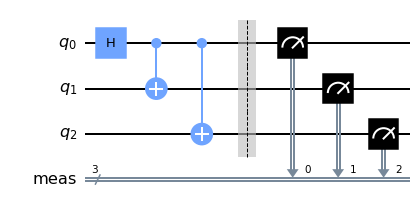

In [30]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.measure_all()
qc.draw('mpl')

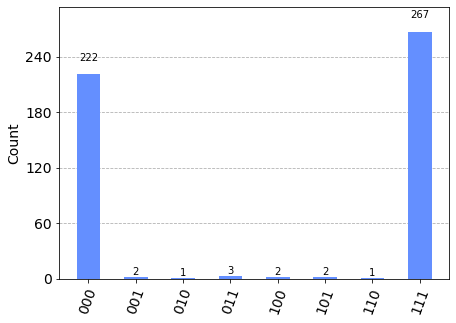

In [32]:
backend = AerSimulator(noise_model = fake_aria)
compiled_QC = transpile(qc, backend)
counts = backend.run(compiled_QC, shots = 500).result().get_counts(compiled_QC)
plot_histogram(counts)